In [8]:
import sys
from pathlib import Path
import os
import numpy as np
from tb_hamiltonian import TBHamiltonian

from tb_hamiltonian.potentials import PotentialFactory
from tb_hamiltonian.utils import get_structure

sys.tracebacklimit = None

# Necessary when connecting to a jupyterhub kernel running on daint via VScode. NOT required otherwise

new_path = '/scratch/snx3000/ajayaraj/tests/periodic-potential/daint/BLG/tb-hamiltonian'
os.chdir(new_path)


In [9]:
nn = 1  # number of nearest neighbors | don't use 0!

workdir = Path(".")

# lengths
lx = 152.0  # length in x direction (Å)
ly = lx / np.sqrt(3)   # length in y direction (Å) keeping the b/a ratio
lz = 10  # length in z direction (Å)
# basepath = workdir / f"len_{lx}x{round(ly,3)}/nn_{nn}"

# or, repetitions
# nx = 3  # number of repetitions in x direction
# ny = 3  # number of repetitions in y direction
# nz = 1  # number of repetitions in z direction
# basepath = workdir / f"rep_{nx}x{ny}/nn_{nn}"

# basepath.mkdir(parents=True, exist_ok=True)


In [10]:
# Define structure

structure = get_structure(
    unit_cell_filepath=workdir / "POSCAR",  # local unit cell file
    lengths=(lx, ly, lz),
    # repetitions=(nx, ny, nz),
    # structure_filepath=f"{basepath}/POSCAR"
)

structure.info["label"] = "BLG"  # will show up at top of Hamiltonian output file


In [11]:
# Compute H

H = TBHamiltonian(
    structure=structure,
    nearest_neighbor=nn,
    distances=(0.0, 1.425, 2.468, 2.850),
    hopping_parameters=(0.0, -2.7, 0.0, -0.27),
    interlayer_coupling=0.33,
)

H.build()

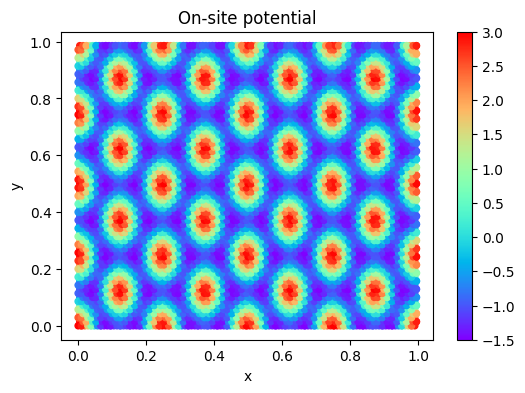

In [12]:
potential = PotentialFactory("triangular-three-wave")
potential.params = {
    "amplitude": 1.0,
    "width": 0.125,
}
H.update_onsite_terms(
    onsite_term=0.0,
    potential=potential,
    alpha=(1.0, 1.0),
)
H.plot_potential()

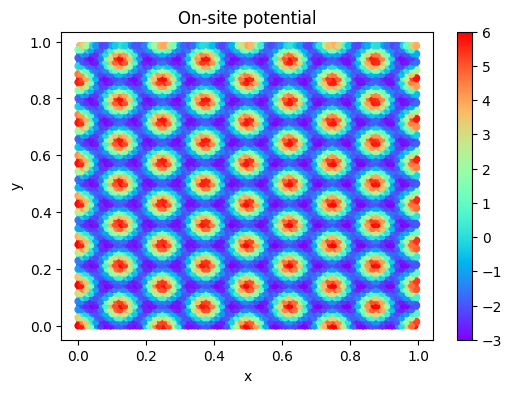

In [13]:
potential = PotentialFactory("triangular-six-wave")
potential.params = {
    "amplitude": 1.0,
    "width":0.125,
}
H.update_onsite_terms(
    onsite_term=0.0,
    potential=potential,
    alpha=(1.0, 1.0),
)
H.plot_potential()

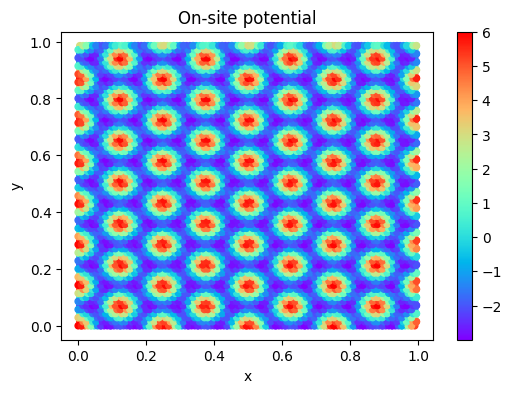

In [14]:
potential = PotentialFactory("superlattice")
potential.params = {
    "amplitude": 1.0,
    # "width": 0.05,
    "qvalue": 50.0,
}
H.update_onsite_terms(
    onsite_term=0.0,
    potential=potential,
    alpha=(1.0, 1.0),
)
H.plot_potential()